## Analysis of movement during different conditions
- Comparing the CS+US vs. CS+ and CS- in movement


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import pingouin as pg
import pymc3 as pm
import arviz as az

In [2]:
subject_list = ['sub-189', 'sub-205', 'sub-071', 'sub-204', 'sub-085', 'sub-100', 'sub-132', 'sub-185', 'sub-167', 'sub-043', 'sub-062', 'sub-073',
       'sub-082', 'sub-030', 'sub-160', 'sub-196', 'sub-1223', 'sub-169', 'sub-1222', 'sub-055', 'sub-170', 'sub-047', 'sub-177', 'sub-130',
       'sub-172', 'sub-200', 'sub-173', 'sub-026', 'sub-059', 'sub-072', 'sub-1232', 'sub-166', 'sub-032', 'sub-016', 'sub-1205', 'sub-186',
       'sub-056', 'sub-053', 'sub-150', 'sub-065', 'sub-154', 'sub-193', 'sub-165', 'sub-103', 'sub-168', 'sub-102', 'sub-048', 'sub-027',
       'sub-182', 'sub-202', 'sub-203', 'sub-066', 'sub-038', 'sub-184', 'sub-171', 'sub-179', 'sub-153', 'sub-144', 'sub-178', 'sub-063',
       'sub-010', 'sub-158', 'sub-083', 'sub-126', 'sub-152']


In [3]:
# read FD
file_temp = '/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/{sub}/ses-1/func/{sub}_ses-1_task-*_desc-confounds_regressors.tsv'
events_temp = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FSL/eventfiles/{sub}.csv'


In [4]:
d = pd.read_csv(glob.glob(file_temp.format(sub='sub-010'))[0], sep="\t").fillna(0)

In [8]:
df = []
for sub in subject_list:
    file = file_temp.format(sub=sub)
    file = glob.glob(file)[0]
    print(file)
    events = events_temp.format(sub=sub)
    fd = pd.read_csv(file, sep='\t').fillna(0)
    fd['framewise_displacement'].values
    # read events file
    ev = pd.read_csv(events)

    # average FD per condition
    fd_mean_us = []
    fd_mean_cs = []
    fd_mean_csm = []
    fd_mean_total = []
    f = fd['framewise_displacement'].values
   
    for i in ev.iterrows():
        on =int(i[1].onset / 2)
        cond = i[1].trial_type
       # print(on)
       # print(cond)
        # average FD
        f_avg = np.mean(f[on:on+2])
       # print(f_avg)
        fd_mean_total.append(f_avg)   
        if (cond=='CSplusUS1' or cond=='CSminusUS2'):
         #   print('US')
            fd_mean_us.append(f_avg)
        elif (cond=='CSplus1' or cond=='CSplus2'):
          #  print('Plus')
            fd_mean_cs.append(f_avg)
        else:
           # print('Minus')
            fd_mean_csm.append(f_avg)
    # conditions for each subject
    conditions = ['US','CS','CSm']
    # average per condition
    fd_s = [np.mean(fd_mean_us), np.mean(fd_mean_cs), np.mean(fd_mean_csm)]
    newD = pd.DataFrame({'subject': pd.Series([sub,sub,sub]), 'cond':pd.Series(conditions), 'fd':pd.Series(fd_s)})
    df.append(newD)

/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/sub-189/ses-1/func/sub-189_ses-1_task-552_desc-confounds_regressors.tsv
/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/sub-205/ses-1/func/sub-205_ses-1_task-552_desc-confounds_regressors.tsv
/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/sub-071/ses-1/func/sub-071_ses-1_task-552_desc-confounds_regressors.tsv
/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/sub-204/ses-1/func/sub-204_ses-1_task-552_desc-confounds_regressors.tsv
/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/sub-085/ses-1/func/sub-085_ses-1_task-552_desc-confounds_regressors.tsv
/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/sub-100/ses-1/func/sub-100_ses-1_task-552_desc-confounds_regressors.tsv
/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/sub-132/ses-1/func/sub-132_ses-1_task-570_desc-confounds_regressors.tsv
/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/sub-185/ses-1/func/sub-1

In [9]:
df2 = pd.concat(df)

In [10]:
df2

,subject,cond,fd
0,sub-189,US,0.161557
1,sub-189,CS,0.111459
2,sub-189,CSm,0.135004
0,sub-205,US,0.107154
1,sub-205,CS,0.103271
...,...,...,...
1,sub-126,CS,0.167514
2,sub-126,CSm,0.187928
0,sub-152,US,0.138973
1,sub-152,CS,0.142968


In [11]:
pg.rm_anova(data=df2, dv='fd', within='cond', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,cond,2,128,2.285206,0.10589,0.034475,0.622016


In [80]:
pg.ttest(df2.fd[df2.cond=='US'],df2.fd[df2.cond=='CSm'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.213248,64,two-sided,0.831811,"[-0.01, 0.01]",0.005987,0.139,0.050259


In [81]:
pg.ttest(df2.fd[df2.cond=='US'],df2.fd[df2.cond=='CS'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.475753,64,two-sided,0.144914,"[-0.0, 0.03]",0.11682,0.381,0.152927


In [82]:
pg.ttest(df2.fd[df2.cond=='CS'],df2.fd[df2.cond=='CSm'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.675672,64,two-sided,0.098682,"[-0.03, 0.0]",0.119293,0.51,0.157454


In [72]:
df2.groupby('cond').describe()

fd                                                              \
     count      mean       std       min       25%       50%       75%   
cond                                                                     
CS    65.0  0.166985  0.092822  0.061886  0.107435  0.141123  0.193194   
CSm   65.0  0.179450  0.114984  0.064717  0.116680  0.142291  0.206081   
US    65.0  0.178781  0.108516  0.069305  0.118852  0.147927  0.207947   

                
           max  
cond            
CS    0.582391  
CSm   0.721009  
US    0.715791

<AxesSubplot:xlabel='cond', ylabel='fd'>

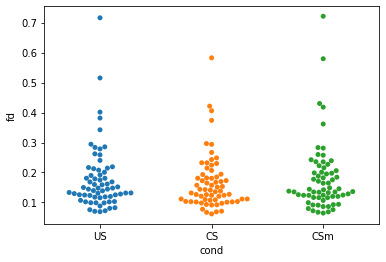

In [75]:
sns.swarmplot(x='cond', y='fd', data=df2)

No difference between the different conditions.

# Bayesian analysis

In [18]:
df2['subject'] = df2['subject'].astype('category')
#df['condition'] = df['condition'].astype('category')

n_sub = len(df2['subject'].unique())
subIDX = df2['subject'].cat.codes.values
# condition
n_cond = len(df2['cond'].unique())
#condIDX = df['condition'].cat.codes.values

# trialNo
y = df2['fd'].values

df2['cond'] = df2['cond'].astype('category')
# generating condition index
condIDX = df2.cond.cat.codes.values

In [23]:
with pm.Model() as model1:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
     
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX])
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=y)
    
    trace = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 507 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [26]:
az.summary(trace, var_names=['mu_a','mu_b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,0.087,0.354,-0.556,0.784,0.006,0.004,3762.0,4626.0,1.0
mu_b,0.086,0.354,-0.585,0.744,0.006,0.004,3785.0,4514.0,1.0


In [27]:
# stacking
trStacked = trace.posterior.stack(draws=('chain','draw'))

In [28]:
csminus = trStacked.b_cond[0,:].values
csplus = trStacked.b_cond[1,:].values
csPlusUS = trStacked.b_cond[2,:].values
csall = np.mean(np.stack([csminus, csplus]), axis=0) # averaging across CSs
usVcs = csPlusUS - csall

Text(0.5, 1.0, 'CSPlusUS-CS Movement')

<Figure size 1296x216 with 0 Axes>

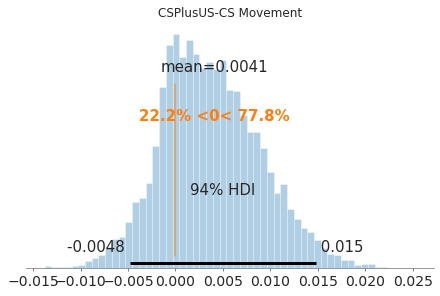

In [31]:
sns.set_style('ticks')
fig = plt.figure(figsize=(18,3))
az.plot_posterior(usVcs, point_estimate='mean', kind='hist', ref_val=0).set_title("CSPlusUS-CS Movement")


In [33]:
sum(usVcs > 0) / 8000

0.778375

In [30]:
print(f'Standardized coeficient {np.mean(usVcs) / np.std(usVcs)}')
az.summary(usVcs)

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


Standardized coeficient 0.7826170462775169


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.004,0.005,-0.005,0.015,0.0,0.0,5767.0,7803.0,NaN
